# An Income Fluctuation Problem with Adjustment Costs
This notebook solves the problem of a household, who faces idiosyncratic income fluctuations. The household can save in an asset with a net return $R$, but must pay a fixed cost $F$:
$$V\big(k,z\big) = max\Big[\underset{inaction}{\underbrace{u\big(Wz+Rk\big) + \beta \mathbb{E}\big[V(k,z)\big]}}, \underset{invest}{\underbrace{\underset{x}{max}\,\,u\big(Wz+Rk-x-F\big) + \beta \mathbb{E}\big[V(k+x,z)\big]}} \Big]$$
With $\log{z_{t+1}} = \rho_z \log{z_t}+ \sigma_z \epsilon_{t+1}$.

In [1]:
using Parameters
using BasisMatrices
using LaTeXStrings
using Plots; pyplot();
using QuantEcon
using FastGaussQuadrature
using MAT                                 # read the .mat file for initial values for c

In [46]:
@with_kw struct KrusselSmithAdjCost
    β::Float64                            # discount factor
    δ::Float64                            # depreciation of capital
    α::Float64                            # capital share
    γ::Float64                            # RRA
    ρz::Float64                           # AR coefficient on individual productivity
    σz::Float64                           # std dev of innovation on individual productivity
    ρA::Float64                           # AR coefficient on productivity
    σA::Float64                           # std dev of innovation of productivity process
    F::Float64                            # Fixed cost of adjustment    
    R::Float64                            # interest rate
    W::Float64                            # wage
end

function KrusselSmithAdjCost(β = 0.98, δ = 0.025, α = 1/3, γ = 1.5, ρz = 0.98, 
                             σz = 0.1, ρA = 0.95, σA = 0.007, F = 0.02, R = 0.01502845)
    W = (1 - α)*((R + δ)/α)^(α/(α-1))
    return KrusselSmithAdjCost(β, δ, α, γ, ρz, σz, ρA, σA, F, R, W)
end

@with_kw mutable struct Household

    model::KrusselSmithAdjCost

    # Solution

    c::Vector{Float64}                    # coefficients on approximate value function
    cE::Vector{Float64}                   # coefficients on approximate expected value function
    x::Vector{Float64}                    # policy

    # Parameters

    Nk::Int64                             # number of nodes for capital
    Nz::Int64                             # number of nodes for individual productivity
    
    gridk::Vector{Float64}                # grid for capital
    gridz::Vector{Float64}                # grid for individual productivity

    s::Matrix{Float64}                    # full state space
    Ns::Int64                             # number of states

    basis::Basis                          # basis of approximate function
    bs::BasisMatrix                       # basis direct matrix
    Φ::SparseMatrixCSC                    # basis expanded matrix
    ΦE::SparseMatrixCSC                   # cE = ΦE * c
end

function Household(model, Nk = 45, Nz = 30)
    
    gridk = 500*linspace(0, 1, Nk) .^ 2.5
    gridz = linspace(-5*√(1/(1 - model.ρz^2))*model.σz, 5*√(1/(1 - model.ρz^2))*model.σz, Nz)
    
    basis = Basis(SplineParams(gridk, 0, 3), SplineParams(gridz, 0, 3))
    
    # the basis functions might need additional nodes at the boundaries
    s, (gridk, gridz) = nodes(basis)
    Ns, Nk, Nz = size(s, 1), size(gridk, 1), size(gridz, 1)
    
    bs = BasisMatrix(basis, Direct())
    Φ = convert(Expanded, bs).vals[1]
    
    (e, w) = gausshermite(6)
    e = model.σz * e
    w = w / sum(w)
    ΦE = spzeros(Ns, Ns)
    
    for j in 1:length(e)
        zprime = max.(min.(model.ρz*s[:,2] + e[j], maximum(gridz)), minimum(gridz))
        ΦE += w[j] * BasisMatrix(basis, Expanded(), hcat(s[:, 1], zprime)).vals[1]
    end
    
    ΦE = convert(SparseMatrixCSC, full(Φ) \ full(ΦE))
    
    c = matread("c.mat")["c"][:,1]
    cE = ΦE * c
    
    return Household(model, c, cE, zeros(Ns), Nk, Nz, gridk, gridz, s, Ns, basis, bs, Φ, ΦE)
end

Household

In [47]:
# evaluates the value of choosing x_i in state i, for all i in vectorized form
function value(hh::Household, x::Vector{Float64})    
    @views 1/(1 - hh.model.γ) .* 
        (hh.model.W .* exp.(hh.s[:, 2]) .+ hh.model.R .* hh.s[:, 1] .- x .- hh.model.F) .^ (1 - hh.model.γ) .+ 
        hh.model.β .* (BasisMatrix(hh.basis, Expanded(), hcat(hh.s[:, 1] + x, hh.s[:, 2]), [0, 0]).vals[1] * hh.cE)    
end

function value_inaction(hh::Household)
    @views 1/(1 - hh.model.γ) .* (hh.model.W .* exp.(hh.s[:, 2]) .+ hh.model.R .* hh.s[:, 1]) .^ (1 - hh.model.γ) .+ 
        hh.model.β .* (BasisMatrix(hh.basis, Expanded(), hcat(hh.s[:, 1], hh.s[:, 2]), [0, 0]).vals[1] * hh.cE)
end

value_inaction (generic function with 1 method)

In [48]:
@inline function policy(hh::Household)
    # cannot dissave more than the capital level
    xmin = - hh.s[:, 1]
    # cannot save such that no consumption is left (Inada!) and such that next periods capital is outside of grid
    xmax = minimum(hcat(hh.model.W * exp.(hh.s[:,2]) + hh.model.R*hh.s[:,1] - hh.model.F - 1e-9, hh.gridk[end] .- hh.s[:,1]), 2)[:, 1]
    
    (xstar, ) = golden_method(x -> value(hh, x), xmin, xmax) #TODO: expensive operation!
    
    return xstar
end

function bellman(hh::Household, prepNewton::Bool)
    
    xstar = policy(hh)
    
    v = value(hh, xstar)::Vector{Float64}
    inactive = value_inaction(hh) .> v
    v = ifelse.(inactive, value_inaction(hh), v)
    
    hh.x = ifelse.(inactive, zeros(hh.Ns), xstar)
    
    vchange = zeros(1)
    Jac = spzeros(1,1)
    
    if prepNewton
        vchange     = (hh.Φ * hh.c - v)::Vector{Float64}
        Jac = (hh.Φ - hh.model.β * BasisMatrix(hh.basis, Expanded(), hcat(hh.s[:, 1] + xstar, hh.s[:,2])).vals[1] * hh.ΦE)::SparseMatrixCSC{Float64, Int64}
    end
    
    return (v, vchange, Jac)
end

bellman (generic function with 1 method)

In [49]:
# solve the household problem, using so many Newton iterations per one complete Bellman
function solve!(hh::Household; stepsNewton = 1)
    
    #plot(hh.gridk, reshape(hh.Φ * hh.c, hh.Nk, hh.Nz)[:,15])
    
    (v, vchange, Jac) = bellman(hh, true)
    hh.c = hh.Φ \ v
    hh.cE = hh.ΦE * hh.c
        
    #plot!(hh.gridk, reshape(hh.Φ * hh.c, hh.Nk, hh.Nz)[:,15])
    
    stop = false
    iteration = 1                         # number of iterations done
    dist = 100
    cold = copy(hh.c)                     # it is better to allocate memory outside of a loop
    
    while !stop
        cold = copy(hh.c)
        
        for i in 1:stepsNewton            # do Newton steps
            hh.c = hh.c - 1/2 * (Jac \ vchange)
            hh.cE = hh.ΦE * hh.c
        end
    
        # do one Bellman
        (v, vchange, Jac) = bellman(hh, true)
        hh.c = hh.Φ \ v
        hh.cE = hh.ΦE * hh.c

        dist = norm(hh.c .- cold)/norm(cold)
        
        println("Iteration: ", iteration, " Distance: ", dist)
        #plot!(hh.gridk, reshape(hh.Φ * hh.c, hh.Nk, hh.Nz)[:,15])
        
        if ((dist < 1e-5) || iteration == 1000)
            stop = true
        end
        iteration += 1
    end
end

solve! (generic function with 1 method)

In [50]:
model = KrusselSmithAdjCost()
hh = Household(model);

In [51]:
@time solve!(hh, stepsNewton=1)

Iteration: 1 Distance: 0.0026729449454596576
Iteration: 2 Distance: 0.001348458673477557
Iteration: 3 Distance: 0.0006771999175819503
Iteration: 4 Distance: 0.0003341695494814944
Iteration: 5 Distance: 0.0001627807600339612
Iteration: 6 Distance: 7.85373410908335e-5
Iteration: 7 Distance: 3.771137739964791e-5
Iteration: 8 Distance: 1.823377559467529e-5
Iteration: 9 Distance: 8.734729494978469e-6
  5.002107 seconds (569.30 k allocations: 3.926 GiB, 21.18% gc time)



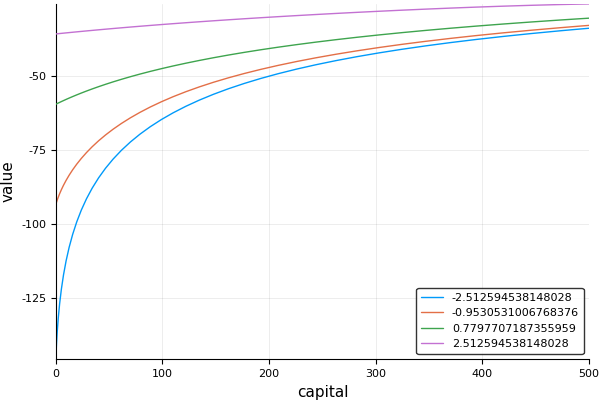

In [52]:
plot(hh.gridk, reshape(hh.Φ * hh.c, hh.Nk, hh.Nz)[:,1], label = hh.gridz[1], xlab = "capital", ylab = "value")
plot!(hh.gridk, reshape(hh.Φ * hh.c, hh.Nk, hh.Nz)[:,11], label = hh.gridz[11])
plot!(hh.gridk, reshape(hh.Φ * hh.c, hh.Nk, hh.Nz)[:,21], label = hh.gridz[21])
plot!(hh.gridk, reshape(hh.Φ * hh.c, hh.Nk, hh.Nz)[:,32], label = hh.gridz[32])


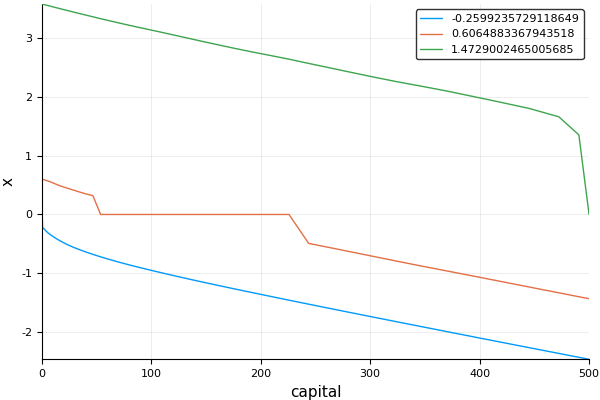

In [53]:
plot(hh.gridk, reshape(hh.x, hh.Nk, hh.Nz)[:,15], label = hh.gridz[15], xlab = "capital", ylab = "x")
plot!(hh.gridk, reshape(hh.x, hh.Nk, hh.Nz)[:,20], label = hh.gridz[20])
plot!(hh.gridk, reshape(hh.x, hh.Nk, hh.Nz)[:,25], label = hh.gridz[25])